In [ ]:
# ESSE EH O QUE FUNCIONA 8/02/2023

In [50]:
# Install the OpenSlide C library and Python bindings
!apt-get install openslide-tools
!pip install openslide-python
!pip install tifffile

#Install libraries
!pip install matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide
import os
import os.path
from PIL import Image
import math
import cv2

from tqdm import tqdm

zsh:1: command not found: apt-get


In [51]:
################################################
# Running utilities/stain_norm functions
################################################

# create_dir, read_slide, grays_filter, img_to_rgb, numpy2RGBpil
# isCenterMaskPositive, isPatchNotFullPositive, 

%run utilities_framework.ipynb

In [56]:
################################################
# Setting folders
################################################

slide_num = '002'

base_path = '../slides_cropped/' + slide_num

all_patches_dir = base_path + '/all_patches/all/' #patches with tissues
classified_patches_dir = base_path + '/classified_patches/' #patches with tissues
segmented_patches_dir = base_path + '/segmented_masks/'
segmented_masks_rounded_dir = base_path + '/segmented_masks_rounded/'
roi_patches_non_binary = base_path + '/roi_patches_non_binary/'
redmensioned_seg_masks_dir = base_path + '/redmensioned_seg_masks/'

In [ ]:
create_directory(alcreate_directory(all_patches_dir)
create_directory(classified_patches_dir)
                 
create_directory(segmented_patches_dir)
create_directory(segmented_masks_rounded_dir)
                 
create_directory(roi_patches_non_binary)
create_directory(redmensioned_seg_masks_dir)

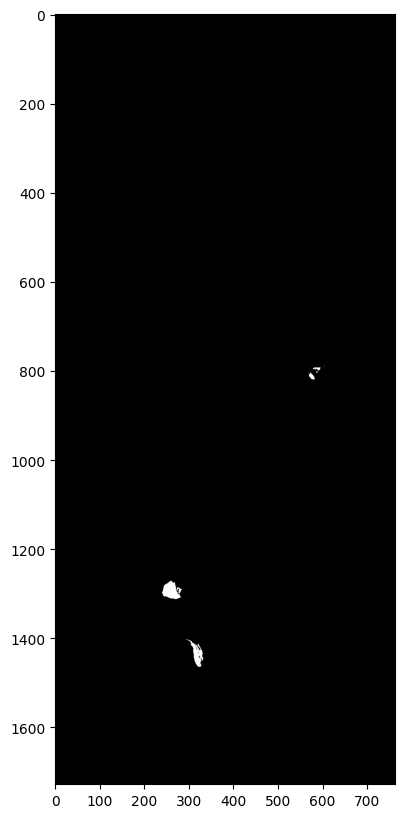

In [64]:
################################################
# Read slide - check slide
################################################

#slide_path = '../slides_to_test/' + slide_num +'/' + 'test_'+ slide_num + '.tif'
slide_path = '../slides_to_test/' + slide_num +'/' + 'tumor_'+ slide_num + '_mask.tif'

slide = open_slide(slide_path)

level_to_plot=7

slide_image = read_slide(slide, 
                          x=0, 
                          y=0, 
                          level=level_to_plot,
                          width=slide.level_dimensions[level_to_plot][0], 
                          height=slide.level_dimensions[level_to_plot][1])

plt.figure(figsize=(10,10))
plt.imshow(slide_image)

In [59]:
################################################
# Patch configs
################################################

def make_square(a, b):
    if (a > b): 
        b = a
    else:
        a = b
    return a, b

def read_img(IMAGE_NAME, DIR):
    read = lambda imname: np.asarray(Image.open(imname))
    PATH = os.path.join(DIR,IMAGE_NAME)
    img = read(PATH)
    return img

level_to_crop = 0
level = 8

itemSizeInPixels = 224 #patch_size
widthInPixels = slide.level_dimensions[level_to_crop][0]
heightInPixels = slide.level_dimensions[level_to_crop][1]

size_y = int(math.ceil(heightInPixels / itemSizeInPixels))
size_x = int(math.ceil(widthInPixels / itemSizeInPixels))
size_y, size_x = make_square(size_y, size_x)

size_x_times_level = int(math.ceil(size_x / level)) * level # making the number a multiple of the level
size_y_times_level = int(math.ceil(size_y / level)) * level
size_y_times_level, size_x_times_level = make_square(size_y_times_level, size_x_times_level)

size_x_by_level = int(math.ceil(size_x / level))
size_y_by_level = int(math.ceil(size_y / level))
size_y_by_level, size_x_by_level = make_square(size_y_by_level, size_x_by_level)


print("# slide_path =", slide_path)
print("# widthInPixels =", widthInPixels)
print("# heightInPixels =", heightInPixels)
print("# ===============================")
print("size_x_times_level =", size_x_times_level)
print("size_y_times_level =", size_y_times_level)

# slide_path = ../slides_to_test/002/tumor_002_mask.tif
# widthInPixels = 97792
# heightInPixels = 221184
# ===============================
size_x_times_level = 992
size_y_times_level = 992


In [60]:
#####################################################
# Cropping ALL the image into patches and saving it
#####################################################

for y in tqdm(range(size_y_times_level)): # round range up or down depending on where you want the black bar
    for x in range(size_x_times_level):  # round range up or down depending on where you want the black bar
        columnStartPixelPosition = x * itemSizeInPixels
        columnEndPixelPosition = columnStartPixelPosition + (itemSizeInPixels - 1)
        rowStartPixelPosition = y * itemSizeInPixels
        rowEndPixelPosition = rowStartPixelPosition + (itemSizeInPixels - 1)
        
        patch_name = str(x) + "_" + str(y) + ".jpg"
        
        cropped_image = read_slide(slide, 
                        x=columnStartPixelPosition,
                        y=rowStartPixelPosition,
                        level=level_to_crop, 
                        width=itemSizeInPixels,
                        height=itemSizeInPixels)
        
        plt.imsave(all_patches_dir + patch_name, cropped_image)

100%|███████████████████████████████| 992/992 [28:10<00:00,  1.70s/it]


In [ ]:
########################################################
###################### *** OR *** ######################
########################################################
########################################################
# Cropping the image where it has TISSUE and saving it
########################################################

numberOfSavedPatchs = 0
numberOfExceptions = 0

for y in tqdm(range(size_y_times_level)): # round range up or down depending on where you want the black bar
    for x in range(size_x_times_level):  # round range up or down depending on where you want the black bar
        columnStartPixelPosition = x * itemSizeInPixels
        columnEndPixelPosition = columnStartPixelPosition + (itemSizeInPixels - 1)
        rowStartPixelPosition = y * itemSizeInPixels
        rowEndPixelPosition = rowStartPixelPosition + (itemSizeInPixels - 1)
        
        patch_name = str(x) + "_" + str(y) + ".jpg"
        
        patch_image = read_slide(slide, 
                        x=columnStartPixelPosition,
                        y=rowStartPixelPosition,
                        level=level_to_crop, 
                        width=itemSizeInPixels,
                        height=itemSizeInPixels)
        
        # Mask To Remove Background
        non_bg_mask = grays_filter(patch_image)
        patchWithoutBackground = patch_image * np.dstack([non_bg_mask, non_bg_mask, non_bg_mask])

        isAllBlack = np.all((patchWithoutBackground == 0))
                
        percentTissueAtPatch = percentTissueAtImage(patchWithoutBackground, patchSize)
        
        # all black === non tissue => Also using 40% because analize made at https://hackmd.io/DqePzvE2Qb-8_V9E_BWvtQ
        if (not isAllBlack and percentTissueAtPatch > 75): 
            try:
                norm_img = normalizeStaining(patch_image)
                mask = img_to_rgb(patch_image)                 
                patch_final = norm_img * np.dstack([mask, mask, mask])
                        
                patch_name = str(x) + "_" + str(y) + ".jpg"
                plt.imsave(all_patches_dir + patch_name, patch_final)
                numberOfSavedPatchs += 1
            except:
                numberOfExceptions += 1
                pass

            
print("# slide_path =", slide_path)
print("# numberOfSavedPatchs =", numberOfSavedPatchs)
print("# numberOfExceptions =", numberOfExceptions)
print("# ===============================")

In [ ]:
####################################################
# Checking the number of files in the output folder
####################################################

path = all_patches_dir

num_files = len([f for f in os.listdir(path)if os.path.isfile(os.path.join(path, f))])
print(path)
print(num_files)